In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal as scs
import scipy.special as ssp
import statistics as stat
from operator import add
from matplotlib import gridspec
from collections import OrderedDict
from labellines import labelLines
import random
import matplotlib

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [8]:
############################################################
nLat = 8192 #32768
nTime = 10
nSims = 700

#nLat = 4096 #32768
#nTime = 64
#nSims = 5000

############################################################
nu = 2.*10**(-3); omega = 0.25 * 50. * 2. * np.sqrt(nu); delt = np.sqrt(nu / 2.) * (1. + 0.4); 
rho = 200. * 2. * np.sqrt(nu) / 2.**3;lamb = delt * np.sqrt(2. / nu)

############################################################
lenLat = 0.5 * 50. / np.sqrt(2. * nu); print(lenLat)
m2eff = 4. * nu * (- 1. + lamb**2); print(m2eff)
alpha = 8.
nCols = 2
n_cross = 2
phi0 = 1
phi_initial = 0.
sigma = 0.005/np.sqrt(m2eff); print(sigma) #0.2/np.sqrt(m2eff)

############################################################
nyq = int(nLat/2)+1; hLat = int(nLat/2); dx = lenLat/nLat
dk = 2.*np.pi/lenLat; dt = dx/alpha; outsize = 4*n_cross*nLat/nTime
dtout = dt*outsize; paper_norm = 1./ phi0 / np.sqrt(2*lenLat)

395.28470752104744
0.007679999999999992
0.05705443307345483


In [9]:
#recombination_time = [time for time in range(nTime) if time%(1/(dtout*np.sqrt(m2eff)))==0]
titles = [r'Field $\phi(x)$', r'$\partial_t \phi(x)$', r'Smoothened $\phi(x)$', r'Smoothened $\partial_t \phi(x)$']
plots = '/home/dpirvu/free_field_correlations/plots/'
plot_sim_suffix = '_for_t'+str(nTime)+'_x'+str(nLat)+'_fields'

## Extract data from files

In [10]:
def extract_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[2:]]
    infile.close()
    return field_values

def sim_location(sim):
    """ sim = simulation number """
    return '/gpfs/dpirvu/pickle_location/free_field_peak_correlator/t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields.dat'

def sim_suffix(sim):
    return '_for_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields'

#def all_real_space_data():
#    all_rsp_data = []
#    for sim in range(nSims):
#        sims_tableau = []
#        for col in range(nCols):
#            simulation = extract_data(sim_location(sim), col)
#            simulation = np.reshape(simulation,(nTime, nLat))
#            sims_tableau.append(simulation)
#        all_rsp_data.append(sims_tableau)
#    print('Data format: ', np.shape(all_rsp_data),' and corresponds to: [simulation, variable, time slice, amplitude]')
#    return(all_rsp_data)

def all_real_space_data():
    all_rsp_data = []
    for sim in range(nSims):
        sims_tableau = []
        for col in range(nCols):
            if col == 0:
                simulation = None
            else:
                simulation = extract_data(sim_location(sim), col)
                simulation = np.reshape(simulation,(nTime, nLat))
            sims_tableau.append(simulation)
        all_rsp_data.append(sims_tableau)
#    print('Data format: ', np.shape(all_rsp_data),' and corresponds to: [simulation, variable, time slice, amplitude]')
    return(all_rsp_data)

def coordinate_data(col, sim, timeslice, spaceslice):
    simulation = extract_data(sim_location(sim), col)
    coordinate = simulation[nLat*timeslice+spaceslice]
    return coordinate

def timeslice_data(col, sim, timeslice):
    simulation = extract_data(sim_location(sim), col)
    timeslice = simulation[nLat*timeslice : nLat*timeslice+nLat]
    return timeslice

def sim_data(col, sim):
    simulation = extract_data(sim_location(sim), col)
    simulation = np.reshape(simulation,(nTime, nLat))
    return simulation

In [5]:
all_real_data = all_real_space_data()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/dpirvu/pickle_location/free_field_peak_correlator/t10_x8192_sim0_fields.dat'

In [11]:
spectrum = [paper_norm * ((dk*k)**2 + m2eff)**(-0.25) for k in range(nyq)]
a = [j-1 if j < nLat/2+1 else nLat-j+1 for j in range(1, nLat+1)]
window = [np.exp(- 0.5 * (i*dx/sigma)**2) / np.sqrt(2*np.pi) / sigma for i in a]
window = window / sum(window)
filter_gauss = np.fft.fft(window, nLat)
fft_field_spectrum = [spectrum[k] for k in range(nyq)]
real_field = np.fft.ifft(fft_field_spectrum, nLat)
real_field = [x + phi_initial for x in real_field]
spectral_field = np.fft.fft(real_field, nLat)
spectral_sm_field = [spectral_field[k]*filter_gauss[k] for k in range(nLat)]
moment = np.sqrt(sum([(spectral_sm_field[k]*np.conj(spectral_sm_field[k])).real for k in range(nyq)]))

In [12]:
data_sm_std = stat.stdev([coordinate_data(1, sim, random.randrange(nTime), random.randrange(nLat)) for sim in range(nSims)])
print(data_sm_std, moment)

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/dpirvu/pickle_location/free_field_peak_correlator/t10_x8192_sim0_fields.dat'

## Data Analysis 

In [13]:
matplotlib.rcParams.update({'font.size': 22})

def add_mask(col, threshold, sim, timeslice):
    mask = np.zeros(nLat)
    field = all_real_data[sim][col][timeslice] #open tableau of field values for each simulation
#    field = timeslice_data(col, sim, timeslice) #open tableau of field values for each simulation
    for i in range(nLat):
        if field[i] >= threshold:
            mask[i] = 1
    return field * mask

def plot_masked_field(col, threshold, sim):
    fig, ax = plt.subplots(1, figsize=(5,4))
    masked_field = [add_mask(col, threshold, sim, timeslice) for timeslice in range(nTime)]
    im=ax.imshow(masked_field, aspect='auto', interpolation='none', origin='lower')     
    plt.colorbar(im, ax=ax)
    ax.set(xlabel = r'$x$', ylabel=r'$t$')
    plt.title('Simulation ' + str(sim+1))
#    plt.savefig(plots_file + 'plot_masked_field' + '_col' + str(col) + plot_sim_suffix + '.png')
    return

def find_peak_positions(col, th, sim, timeslice):
    """ Finds x coordinate of peaks in smoothened field for mask applied at threshold. """
    smoothened_field = all_real_data[sim][col][timeslice]
    peak_positions = scs.find_peaks(smoothened_field, height = th)[0].tolist()
#    smoothened_field = add_mask(col, th, sim, timeslice)
#    peak_positions = scs.find_peaks(smoothened_field, height = th)[0].tolist()
    if smoothened_field[-1] > th and smoothened_field[0] > th and smoothened_field[-1] != smoothened_field[0]:
        if smoothened_field[0] > smoothened_field[-1] and smoothened_field[0] > smoothened_field[1]:
            peak_positions.append(0)
        elif smoothened_field[0] < smoothened_field[-1] and smoothened_field[-1] > smoothened_field[-2]:
            peak_positions.append(nLat-1) # this minds potential boundary discontinuities
    return peak_positions

def peak_number_density_est(thr):
    N_gal = 0.
    counter = 0.
    for sim in range(nSims):
#        for t in range(nTime):
            peak_coordinates = find_peak_positions(1, thr, sim, random.randrange(nTime))
            N_gal += len(peak_coordinates)
            counter += 1
    return N_gal / nLat / counter

def analytic_peak_number_density(threshold, N):
    """ Units of zeroth moment """
    thr = threshold / moment
    if N == 8192 and sigma == 0.005/np.sqrt(m2eff):
        return 1.39484+np.exp(-0.5*thr**2)*(0.416284+0.416284*ssp.erf(0.22111*thr))-1.39484*ssp.erf(0.740871*thr)
    
nu = 4
th = [i/4. for i in range(4*nu+1)]
thr = [i/100. for i in range(100*nu+1)]

plt.figure(figsize=(7,5))
plt.plot(th, [peak_number_density_est(i*data_sm_std) for i in th], 'bo')
plt.plot(thr, [analytic_peak_number_density(i*data_sm_std, nLat)*dx for i in thr], color='green', ls='--')

plt.xlabel(r'$\nu_t$')
plt.ylabel(r'$n(\nu_t)$')
plt.grid()
plt.show()

NameError: name 'data_sm_std' is not defined

<Figure size 504x360 with 0 Axes>

In [19]:
# Theoretical correlators from Mathematica Notebook
def thnu(th, N):
    thr = th / moment
    if N == 8192 and sigma == 0.005/np.sqrt(m2eff):
        if thr == 3:
            return [-1.000,-1.000,-0.9999,5.284,10.78,16.66,25.47,33.98,42.33,49.83,55.91,60.33,63.07,64.32,64.37,63.53,62.09,60.27,58.27,56.23,54.23,52.33,50.55,48.91,47.40,46.02,44.74,43.55,42.44,41.41,40.43,39.51,38.64,37.81,37.01,36.25,35.53,34.83,34.16,33.51,32.89,32.30,31.72,31.16,30.62,30.11,29.60,29.12,28.64,28.19,27.74,27.31,26.90,26.49,26.10,25.71,25.34,24.98,24.63,24.28,23.95,23.62,23.31,23.00,22.69,22.40,22.11,21.83,21.56,21.29,21.03,20.77,20.52,20.28,20.04,19.80,19.57,19.35,19.13,18.91,18.70,18.49,18.29,18.09,17.90,17.71,17.52,17.34,17.16,16.98,16.81,16.64,16.47,16.30,16.14,15.98,15.83,15.67,15.52,15.38,15.23,15.09,14.95,14.81,14.67,14.54,14.41,14.28,14.15,14.02,13.90,13.78,13.66,13.54,13.42,13.31,13.20,13.08,12.97,12.87,12.76,12.65,12.55,12.45,12.35,12.25,12.15,12.05,11.96,11.87,11.77,11.68,11.59,11.50,11.41,11.33,11.24,11.16,11.07,10.99,10.91,10.83,10.75,10.67,10.60,10.52,10.44,10.37,10.30,10.22,10.15,10.08,10.01,9.944,9.876,9.808,9.741,9.675,9.609,9.544,9.480,9.417,9.354,9.292,9.231,9.171,9.111,9.051,8.993,8.935,8.877,8.820,8.764,8.709,8.654,8.599,8.545,8.492,8.439,8.387,8.335,8.290,8.234,8.183,8.134,8.085,8.036,7.988,7.940,7.893,7.846,7.800,7.754,7.708,7.663,7.618,7.574,7.531,7.487,7.444,7.402,7.359,7.318,7.276,7.235,7.195,7.154,7.114,7.075,7.036,6.997,6.958,6.920,6.882,6.845,6.808,6.771,6.734,6.698,6.662,6.626,6.591,6.556,6.521,6.487,6.453,6.419,6.386,6.352,6.319,6.287,6.254,6.222,6.190,6.158,6.127,6.096,6.065,6.034,6.004,5.973,5.944,5.914,5.884,5.855,5.826,5.797,5.769,5.740,5.712,5.684,5.656,5.629,5.602,5.575,5.548,5.521,5.495,5.468,5.442,5.417,5.391,5.365,5.340,5.315,5.290,5.265,5.241,5.216,5.192,5.168,5.144,5.120,5.097,5.073,5.050,5.027,5.004,4.982,4.959,4.937,4.914,4.892,4.870,4.849,4.827,4.805,4.784,4.763,4.742,4.721,4.700,4.679,4.659,4.639,4.618,4.598,4.578,4.558,4.539,4.519,4.500,4.480,4.461,4.442,4.423,4.404,4.386,4.367,4.349,4.330,4.312,4.294,4.276,4.258,4.240,4.223,4.205,4.188,4.171,4.153,4.136,4.119,4.102,4.086,4.069,4.052,4.036,4.019,4.003,3.987,3.971,3.955,3.939,3.923,3.907,3.892,3.876,3.861,3.846,3.830,3.815,3.800,3.785,3.770,3.755,3.741,3.726,3.712,3.697,3.683,3.668,3.654,3.640,3.626,3.612,3.598,3.584,3.571,3.557,3.543,3.530,3.516,3.503,3.490,3.477,3.464,3.450,3.438,3.425,3.412,3.399,3.386,3.374,3.361,3.349,3.336,3.324,3.312,3.299,3.287,3.275,3.263,3.251,3.239,3.227,3.216,3.204,3.192,3.181,3.169,3.158,3.146,3.135,3.124,3.112,3.101,3.090,3.079,3.068,3.057,3.046,3.035,3.025,3.014,3.003,2.993,2.982,2.972,2.961,2.951,2.940,2.930,2.920,2.910,2.900,2.889,2.879,2.869,2.859,2.850,2.840,2.830,2.820,2.811,2.801,2.791,2.782,2.772,2.763,2.753,2.744,2.735,2.725,2.716,2.707,2.698,2.689,2.680,2.671,2.662,2.653,2.644,2.635,2.626,2.617,2.609,2.600,2.591,2.583,2.574,2.566,2.557,2.549,2.541,2.532,2.524,2.516,2.507,2.499,2.491,2.483,2.475,2.467,2.459,2.451,2.443,2.435,2.427,2.419,2.411,2.403,2.396,2.388,2.380,2.373,2.365,2.358,2.350,2.343,2.335,2.328,2.321,2.314,2.306,2.299,2.291,2.284,2.277,2.269,2.262,2.255,2.248,2.241,2.234,2.227,2.220,2.213,2.206,2.199,2.193,2.186,2.179,2.172,2.165,2.159,2.152,2.145,2.139,2.132,2.126,2.119,2.113,2.106,2.100,2.093,2.087,2.081,2.074,2.068,2.062,2.055,2.049,2.043,2.037,2.031,2.025,2.018,2.012,2.006,2.000,1.994,1.988,1.982,1.976,1.970,1.965,1.959,1.953,1.947,1.941,1.936,1.930,1.924,1.918,1.913,1.907,1.901,1.896,1.890,1.885,1.879,1.874,1.868,1.863,1.857,1.852,1.846,1.841,1.836,1.830,1.825,1.820,1.814,1.809,1.804,1.799,1.793,1.788,1.783,1.778,1.773,1.768,1.762,1.757,1.752,1.747,1.742,1.737,1.732,1.727,1.722,1.718,1.713,1.708,1.703,1.698,1.693,1.688,1.684,1.679,1.674,1.669,1.665,1.660,1.655,1.651,1.646,1.641,1.637,1.632,1.628,1.623,1.618,1.614,1.609,1.605,1.600,1.596,1.592,1.587,1.583,1.578,1.574,1.570,1.565,1.561,1.557,1.552,1.548,1.544,1.539,1.535,1.531,1.527,1.523,1.518,1.514,1.510,1.506,1.502,1.498,1.494,1.490,1.486,1.481,1.477,1.473,1.469,1.465,1.461,1.457,1.453,1.450,1.446,1.442,1.438,1.434,1.430,1.426,1.422,1.419,1.415,1.411,1.407,1.403,1.400,1.396,1.392,1.388,1.385,1.381,1.377,1.374,1.370,1.366,1.363,1.359,1.355,1.352,1.348,1.345,1.341,1.337,1.334,1.330,1.327,1.323,1.320,1.316,1.313,1.309,1.306,1.303,1.299,1.296,1.292,1.289,1.286,1.282,1.279,1.276,1.272,1.269,1.266,1.262,1.259,1.256,1.252,1.249,1.246,1.243,1.239,1.236,1.233,1.230,1.227,1.223,1.220,1.217,1.214,1.211,1.208,1.205,1.201,1.198,1.195,1.192,1.189,1.186,1.183,1.180,1.177,1.174,1.171,1.168,1.165,1.162,1.159,1.156,1.153,1.150,1.147,1.144,1.141,1.138,1.136,1.133,1.130,1.127,1.124,1.121,1.118,1.115,1.113,1.110,1.107,1.104,1.101,1.099,1.096,1.093,1.090,1.088,1.085,1.082,1.079,1.077,1.074,1.071,1.069,1.066,1.063,1.061,1.058,1.055,1.053,1.050,1.047,1.045,1.042,1.040,1.037,1.034,1.032,1.029,1.027,1.024,1.022,1.019,1.016,1.014,1.011,1.009,1.006,1.004,1.001,0.9994,0.9969,0.9944,0.9920,0.9895,0.9871,0.9846,0.9822,0.9798,0.9774,0.9749,0.9725,0.9701,0.9678,0.9654,0.9630,0.9606,0.9583,0.9559,0.9536,0.9512,0.9489,0.9466,0.9442,0.9419,0.9396,0.9373,0.9350,0.9327,0.9305,0.9282,0.9259,0.9237,0.9214,0.9192,0.9169,0.9147,0.9125,0.9102,0.9080,0.9058,0.9036,0.9014,0.8992,0.8970,0.8949,0.8927,0.8905,0.8884,0.8862,0.8841,0.8819,0.8798,0.8776,0.8755,0.8734,0.8713,0.8692,0.8671,0.8650,0.8629,0.8608,0.8587,0.8567,0.8546,0.8525,0.8505,0.8484,0.8464,0.8444,0.8423,0.8403,0.8383,0.8363,0.8343,0.8323,0.8303,0.8283,0.8263,0.8243,0.8223,0.8203,0.8184,0.8164,0.8145,0.8125,0.8106,0.8086,0.8067,0.8048,0.8028,0.8009,0.7990,0.7971,0.7952,0.7933,0.7914,0.7895,0.7876,0.7858,0.7839,0.7820,0.7802,0.7783,0.7765,0.7746,0.7728,0.7709,0.7691,0.7673,0.7654,0.7636,0.7618,0.7600,0.7582,0.7564,0.7546,0.7528,0.7510,0.7493,0.7475,0.7457,0.7440,0.7422,0.7404,0.7387,0.7369,0.7352,0.7335,0.7317,0.7300,0.7283,0.7265,0.7248,0.7231,0.7214,0.7197,0.7180,0.7163,0.7146,0.7130,0.7113,0.7096,0.7079,0.7063,0.7046,0.7029,0.7013,0.6996,0.6980,0.6963,0.6947,0.6931,0.6914,0.6898,0.6882,0.6866,0.6850,0.6834,0.6818,0.6802,0.6786,0.6770,0.6754,0.6738,0.6722,0.6707,0.6691,0.6675,0.6659,0.6644,0.6628,0.6613,0.6597,0.6582,0.6567,0.6551,0.6536,0.6521,0.6505,0.6490,0.6475,0.6460,0.6445,0.6430,0.6415,0.6400,0.6385,0.6370,0.6355,0.6340,0.6325,0.6311,0.6296,0.6281,0.6267,0.6252,0.6237,0.6223,0.6208,0.6194,0.6179,0.6165,0.6151,0.6136,0.6122,0.6108,0.6094,0.6079,0.6065,0.6051,0.6037,0.6023,0.6009,0.5995,0.5981,0.5967,0.5953,0.5939,0.5926,0.5912,0.5898,0.5884,0.5871,0.5857,0.5843,0.5830,0.5816,0.5803,0.5789,0.5776,0.5763,0.5749,0.5736]
        if thr == 2.5:
            return [-1.000,-1.000,-0.9999,-0.6466,2.176,3.858,6.554,9.240,11.96,14.53,16.72,18.43,19.63,20.33,20.60,20.55,20.27,19.83,19.30,18.74,18.17,17.63,17.12,16.65,16.21,15.82,15.45,15.11,14.80,14.51,14.23,13.97,13.72,13.48,13.26,13.04,12.83,12.63,12.44,12.26,12.08,11.90,11.73,11.57,11.41,11.26,11.11,10.97,10.83,10.69,10.56,10.43,10.30,10.18,10.06,9.946,9.832,9.721,9.612,9.506,9.403,9.302,9.203,9.106,9.011,8.918,8.827,8.738,8.651,8.566,8.482,8.400,8.320,8.241,8.164,8.088,8.013,7.940,7.869,7.798,7.729,7.661,7.594,7.529,7.464,7.401,7.338,7.277,7.217,7.157,7.099,7.041,6.985,6.929,6.876,6.821,6.767,6.715,6.663,6.613,6.563,6.513,6.465,6.417,6.370,6.323,6.277,6.232,6.187,6.143,6.100,6.057,6.014,5.973,5.931,5.891,5.851,5.812,5.773,5.733,5.695,5.657,5.620,5.583,5.547,5.511,5.476,5.441,5.406,5.372,5.338,5.305,5.272,5.239,5.207,5.175,5.143,5.112,5.081,5.051,5.020,4.991,4.961,4.932,4.903,4.874,4.846,4.818,4.790,4.763,4.736,4.709,4.682,4.656,4.630,4.604,4.578,4.553,4.528,4.503,4.479,4.454,4.430,4.406,4.383,4.359,4.336,4.313,4.290,4.268,4.246,4.223,4.201,4.180,4.158,4.137,4.116,4.095,4.074,4.053,4.033,4.013,3.993,3.973,3.953,3.933,3.914,3.895,3.876,3.857,3.838,3.820,3.801,3.783,3.765,3.747,3.729,3.711,3.694,3.676,3.659,3.642,3.625,3.608,3.591,3.575,3.558,3.542,3.526,3.510,3.494,3.478,3.462,3.447,3.431,3.416,3.400,3.385,3.370,3.356,3.341,3.326,3.311,3.297,3.283,3.268,3.254,3.240,3.226,3.212,3.198,3.185,3.171,3.158,3.144,3.131,3.118,3.105,3.092,3.079,3.066,3.053,3.040,3.028,3.015,3.003,2.991,2.978,2.966,2.954,2.942,2.930,2.918,2.907,2.895,2.883,2.872,2.860,2.849,2.838,2.826,2.815,2.804,2.793,2.782,2.771,2.760,2.749,2.739,2.728,2.718,2.707,2.697,2.686,2.676,2.666,2.656,2.645,2.635,2.625,2.615,2.606,2.596,2.586,2.576,2.567,2.557,2.548,2.538,2.529,2.519,2.510,2.501,2.492,2.482,2.473,2.464,2.455,2.446,2.437,2.429,2.420,2.411,2.402,2.394,2.385,2.376,2.368,2.360,2.351,2.343,2.334,2.326,2.318,2.310,2.302,2.294,2.286,2.277,2.270,2.262,2.254,2.246,2.238,2.230,2.223,2.215,2.207,2.200,2.192,2.185,2.177,2.170,2.162,2.155,2.148,2.140,2.133,2.126,2.119,2.112,2.105,2.098,2.090,2.084,2.077,2.070,2.063,2.056,2.049,2.042,2.036,2.029,2.022,2.015,2.009,2.002,1.996,1.989,1.983,1.976,1.970,1.963,1.957,1.951,1.944,1.938,1.932,1.926,1.920,1.913,1.907,1.901,1.895,1.889,1.883,1.877,1.871,1.865,1.859,1.853,1.848,1.842,1.836,1.830,1.824,1.819,1.813,1.807,1.802,1.796,1.791,1.785,1.780,1.774,1.769,1.763,1.758,1.752,1.747,1.741,1.736,1.731,1.726,1.720,1.715,1.710,1.705,1.699,1.694,1.689,1.684,1.679,1.674,1.669,1.664,1.659,1.654,1.649,1.644,1.639,1.634,1.629,1.624,1.620,1.615,1.610,1.605,1.601,1.596,1.591,1.586,1.582,1.577,1.572,1.568,1.563,1.559,1.554,1.550,1.545,1.541,1.536,1.532,1.527,1.523,1.518,1.514,1.510,1.505,1.501,1.497,1.492,1.488,1.484,1.480,1.475,1.471,1.467,1.463,1.459,1.454,1.450,1.446,1.442,1.438,1.434,1.430,1.426,1.422,1.418,1.414,1.410,1.406,1.402,1.398,1.394,1.390,1.386,1.382,1.379,1.375,1.371,1.367,1.363,1.360,1.356,1.352,1.348,1.345,1.341,1.337,1.334,1.330,1.326,1.323,1.319,1.315,1.312,1.308,1.305,1.301,1.298,1.294,1.290,1.287,1.283,1.280,1.277,1.273,1.270,1.266,1.263,1.259,1.256,1.253,1.249,1.246,1.243,1.239,1.236,1.233,1.229,1.226,1.223,1.219,1.216,1.213,1.210,1.207,1.203,1.200,1.197,1.194,1.191,1.188,1.184,1.181,1.178,1.175,1.172,1.169,1.166,1.163,1.160,1.157,1.154,1.151,1.148,1.145,1.142,1.139,1.136,1.133,1.130,1.127,1.124,1.121,1.118,1.115,1.112,1.110,1.107,1.104,1.101,1.098,1.095,1.093,1.090,1.087,1.084,1.081,1.079,1.076,1.073,1.070,1.068,1.065,1.062,1.059,1.057,1.054,1.051,1.049,1.046,1.043,1.041,1.038,1.035,1.033,1.030,1.028,1.025,1.022,1.020,1.017,1.015,1.012,1.010,1.007,1.005,1.002,1.000,0.9975,0.9950,0.9925,0.9901,0.9876,0.9851,0.9827,0.9802,0.9778,0.9753,0.9728,0.9704,0.9680,0.9656,0.9632,0.9608,0.9584,0.9561,0.9537,0.9515,0.9491,0.9468,0.9444,0.9421,0.9398,0.9375,0.9352,0.9329,0.9306,0.9283,0.9260,0.9237,0.9215,0.9192,0.9170,0.9147,0.9125,0.9103,0.9080,0.9058,0.9036,0.9014,0.8992,0.8971,0.8949,0.8927,0.8905,0.8884,0.8862,0.8841,0.8819,0.8798,0.8777,0.8755,0.8734,0.8713,0.8692,0.8671,0.8650,0.8630,0.8609,0.8588,0.8567,0.8547,0.8526,0.8506,0.8485,0.8465,0.8445,0.8425,0.8404,0.8384,0.8364,0.8344,0.8324,0.8305,0.8285,0.8265,0.8245,0.8226,0.8206,0.8187,0.8167,0.8148,0.8128,0.8109,0.8090,0.8071,0.8051,0.8032,0.8013,0.7994,0.7975,0.7957,0.7938,0.7919,0.7900,0.7882,0.7863,0.7844,0.7826,0.7808,0.7789,0.7771,0.7753,0.7734,0.7716,0.7698,0.7680,0.7662,0.7644,0.7626,0.7608,0.7590,0.7572,0.7555,0.7537,0.7519,0.7502,0.7484,0.7467,0.7449,0.7432,0.7415,0.7397,0.7380,0.7363,0.7346,0.7329,0.7312,0.7295,0.7278,0.7261,0.7244,0.7227,0.7210,0.7194,0.7177,0.7160,0.7144,0.7127,0.7111,0.7094,0.7078,0.7062,0.7045,0.7029,0.7013,0.6997,0.6981,0.6964,0.6948,0.6932,0.6916,0.6901,0.6885,0.6869,0.6853,0.6837,0.6822,0.6806,0.6790,0.6775,0.6759,0.6744,0.6728,0.6713,0.6697,0.6682,0.6667,0.6652,0.6636,0.6621,0.6606,0.6591,0.6576,0.6561,0.6546,0.6531,0.6516,0.6501,0.6487,0.6472,0.6457,0.6442,0.6428,0.6413,0.6399,0.6384,0.6369,0.6355,0.6341,0.6326,0.6312,0.6298,0.6283,0.6269,0.6255,0.6241,0.6226,0.6212,0.6198,0.6184,0.6170,0.6156,0.6142,0.6129,0.6115,0.6101,0.6087,0.6073,0.6060,0.6046,0.6032,0.6019,0.6005,0.5992,0.5978,0.5965,0.5951,0.5938,0.5925,0.5911,0.5898,0.5885,0.5871,0.5858,0.5845,0.5832,0.5819,0.5806,0.5793,0.5780,0.5767,0.5754,0.5741,0.5728,0.5715,0.5703,0.5690,0.5677,0.5664,0.5652,0.5639,0.5626,0.5614,0.5601,0.5589,0.5576,0.5564,0.5552,0.5539,0.5527,0.5514,0.5502,0.5490,0.5478,0.5465,0.5453,0.5441,0.5429,0.5417,0.5405,0.5393,0.5381,0.5369,0.5357,0.5345,0.5333,0.5321,0.5309,0.5298,0.5286,0.5274,0.5262,0.5251,0.5239,0.5227,0.5216,0.5204,0.5193,0.5181,0.5170,0.5158,0.5147,0.5135,0.5124,0.5113,0.5101,0.5090,0.5079,0.5068,0.5056,0.5045,0.5034,0.5023,0.5012,0.5001,0.4990,0.4979,0.4968,0.4957,0.4946,0.4935,0.4924,0.4913,0.4902,0.4891,0.4881,0.4870,0.4859,0.4848,0.4838,0.4827,0.4816,0.4806,0.4795,0.4785,0.4774,0.4763,0.4753,0.4742,0.4732,0.4722,0.4711,0.4701,0.4690,0.4680,0.4670,0.4660,0.4649,0.4639,0.4629,0.4619,0.4609,0.4598,0.4589,0.4579,0.4568,0.4558,0.4548,0.4538,0.4528,0.4518,0.4509,0.4499,0.4488,0.4479,0.4469,0.4459,0.4449,0.4439,0.4430,0.4420,0.4410,0.4400,0.4391,0.4381,0.4371,0.4362,0.4352,0.4343,0.4333,0.4324,0.4314,0.4305,0.4295,0.4286,0.4277,0.4267,0.4258,0.4248,0.4239,0.4230,0.4221,0.4211,0.4202,0.4193,0.4184,0.4175,0.4165,0.4156,0.4147,0.4138,0.4129,0.4120,0.4111,0.4102,0.4093,0.4084,0.4075,0.4066,0.4057,0.4048,0.4040,0.4031,0.4022,0.4013,0.4004,0.3995,0.3987,0.3978,0.3969,0.3961,0.3952,0.3943,0.3935,0.3926,0.3917,0.3909,0.3900,0.3892,0.3883,0.3875,0.3866,0.3858,0.3849,0.3841]
        if thr == 2:
            return [-1.000,-1.000,-0.9999,-0.4756,0.03885,0.6277,1.634,2.659,3.751,4.796,5.732,6.508,7.089,7.473,7.682,7.746,7.703,7.586,7.424,7.238,7.047,6.859,6.682,6.519,6.369,6.233,6.109,5.995,5.890,5.792,5.701,5.615,5.533,5.455,5.381,5.310,5.241,5.175,5.112,5.050,4.990,4.932,4.876,4.822,4.769,4.717,4.667,4.619,4.571,4.524,4.479,4.435,4.392,4.350,4.309,4.268,4.229,4.190,4.153,4.116,4.080,4.044,4.009,3.975,3.942,3.909,3.877,3.845,3.814,3.784,3.754,3.725,3.696,3.668,3.640,3.612,3.586,3.559,3.533,3.507,3.482,3.457,3.433,3.409,3.385,3.362,3.339,3.316,3.293,3.271,3.250,3.228,3.207,3.186,3.166,3.146,3.126,3.106,3.086,3.067,3.048,3.029,3.011,2.993,2.975,2.957,2.939,2.922,2.905,2.888,2.871,2.855,2.838,2.822,2.806,2.790,2.775,2.759,2.744,2.729,2.714,2.699,2.685,2.670,2.656,2.642,2.628,2.614,2.600,2.587,2.573,2.560,2.547,2.534,2.521,2.508,2.495,2.483,2.471,2.458,2.446,2.434,2.422,2.410,2.399,2.387,2.376,2.364,2.353,2.342,2.331,2.320,2.309,2.298,2.288,2.277,2.267,2.256,2.246,2.236,2.225,2.215,2.205,2.195,2.186,2.176,2.166,2.157,2.147,2.138,2.128,2.119,2.110,2.101,2.092,2.083,2.074,2.065,2.056,2.047,2.039,2.030,2.022,2.013,2.005,1.997,1.989,1.980,1.972,1.964,1.956,1.948,1.940,1.932,1.925,1.917,1.909,1.902,1.894,1.887,1.879,1.872,1.864,1.857,1.850,1.843,1.835,1.828,1.821,1.814,1.807,1.800,1.793,1.787,1.780,1.773,1.766,1.760,1.753,1.747,1.740,1.734,1.727,1.721,1.714,1.708,1.702,1.696,1.689,1.683,1.677,1.671,1.665,1.659,1.653,1.647,1.641,1.635,1.630,1.624,1.618,1.612,1.607,1.601,1.595,1.590,1.584,1.579,1.573,1.568,1.562,1.557,1.552,1.546,1.541,1.536,1.530,1.525,1.520,1.515,1.510,1.505,1.499,1.494,1.489,1.484,1.480,1.475,1.470,1.465,1.460,1.455,1.450,1.445,1.441,1.436,1.431,1.427,1.422,1.417,1.413,1.408,1.404,1.399,1.395,1.390,1.386,1.381,1.377,1.372,1.368,1.364,1.359,1.355,1.351,1.346,1.342,1.338,1.334,1.330,1.325,1.321,1.317,1.313,1.309,1.305,1.301,1.297,1.293,1.289,1.285,1.281,1.277,1.273,1.269,1.265,1.261,1.258,1.254,1.250,1.246,1.243,1.239,1.235,1.231,1.228,1.224,1.220,1.217,1.213,1.209,1.206,1.202,1.199,1.195,1.192,1.188,1.185,1.181,1.178,1.174,1.171,1.167,1.164,1.161,1.157,1.154,1.150,1.147,1.144,1.141,1.137,1.134,1.131,1.127,1.124,1.121,1.118,1.115,1.111,1.108,1.105,1.102,1.099,1.096,1.093,1.090,1.087,1.083,1.080,1.077,1.074,1.071,1.068,1.065,1.062,1.059,1.057,1.054,1.051,1.048,1.045,1.042,1.039,1.036,1.033,1.031,1.028,1.025,1.022,1.019,1.017,1.014,1.011,1.008,1.005,1.003,1.000,0.9978,0.9951,0.9924,0.9897,0.9870,0.9844,0.9817,0.9791,0.9765,0.9739,0.9712,0.9686,0.9661,0.9635,0.9609,0.9584,0.9558,0.9533,0.9508,0.9482,0.9457,0.9432,0.9407,0.9383,0.9358,0.9333,0.9309,0.9284,0.9260,0.9236,0.9211,0.9187,0.9163,0.9139,0.9116,0.9092,0.9068,0.9045,0.9021,0.8998,0.8975,0.8951,0.8928,0.8905,0.8882,0.8859,0.8836,0.8814,0.8791,0.8769,0.8746,0.8724,0.8701,0.8679,0.8657,0.8635,0.8613,0.8591,0.8569,0.8547,0.8526,0.8504,0.8482,0.8461,0.8440,0.8418,0.8397,0.8376,0.8355,0.8334,0.8313,0.8292,0.8271,0.8250,0.8230,0.8209,0.8188,0.8168,0.8148,0.8127,0.8107,0.8087,0.8067,0.8047,0.8027,0.8007,0.7987,0.7967,0.7947,0.7928,0.7908,0.7889,0.7869,0.7850,0.7830,0.7811,0.7792,0.7773,0.7754,0.7735,0.7716,0.7697,0.7678,0.7659,0.7641,0.7622,0.7603,0.7585,0.7566,0.7548,0.7530,0.7511,0.7493,0.7475,0.7457,0.7439,0.7421,0.7403,0.7385,0.7367,0.7350,0.7332,0.7314,0.7297,0.7279,0.7262,0.7244,0.7227,0.7209,0.7192,0.7175,0.7158,0.7141,0.7124,0.7107,0.7090,0.7073,0.7056,0.7039,0.7022,0.7006,0.6989,0.6973,0.6956,0.6940,0.6923,0.6907,0.6890,0.6874,0.6858,0.6842,0.6826,0.6810,0.6793,0.6777,0.6762,0.6746,0.6730,0.6714,0.6698,0.6683,0.6667,0.6651,0.6636,0.6620,0.6605,0.6589,0.6574,0.6559,0.6543,0.6528,0.6513,0.6498,0.6483,0.6468,0.6453,0.6438,0.6423,0.6408,0.6393,0.6378,0.6364,0.6349,0.6334,0.6320,0.6305,0.6291,0.6276,0.6262,0.6247,0.6233,0.6219,0.6204,0.6190,0.6176,0.6162,0.6147,0.6133,0.6119,0.6105,0.6091,0.6078,0.6064,0.6050,0.6036,0.6022,0.6009,0.5995,0.5981,0.5968,0.5954,0.5941,0.5927,0.5914,0.5900,0.5887,0.5873,0.5860,0.5847,0.5834,0.5820,0.5807,0.5794,0.5781,0.5768,0.5755,0.5742,0.5729,0.5716,0.5703,0.5691,0.5678,0.5665,0.5652,0.5640,0.5627,0.5614,0.5602,0.5589,0.5577,0.5564,0.5552,0.5539,0.5527,0.5515,0.5502,0.5490,0.5478,0.5466,0.5453,0.5441,0.5429,0.5417,0.5405,0.5393,0.5381,0.5369,0.5357,0.5345,0.5333,0.5322,0.5310,0.5298,0.5286,0.5275,0.5263,0.5251,0.5240,0.5228,0.5217,0.5205,0.5194,0.5182,0.5171,0.5159,0.5148,0.5137,0.5125,0.5114,0.5103,0.5092,0.5080,0.5069,0.5058,0.5047,0.5036,0.5025,0.5014,0.5003,0.4992,0.4981,0.4970,0.4959,0.4948,0.4938,0.4927,0.4916,0.4905,0.4895,0.4884,0.4873,0.4863,0.4852,0.4841,0.4831,0.4820,0.4810,0.4799,0.4789,0.4779,0.4768,0.4758,0.4748,0.4737,0.4727,0.4717,0.4706,0.4696,0.4686,0.4676,0.4666,0.4656,0.4646,0.4636,0.4626,0.4616,0.4606,0.4596,0.4586,0.4576,0.4566,0.4556,0.4546,0.4536,0.4527,0.4517,0.4507,0.4498,0.4488,0.4478,0.4469,0.4459,0.4449,0.4440,0.4430,0.4421,0.4411,0.4402,0.4392,0.4383,0.4373,0.4364,0.4355,0.4345,0.4336,0.4327,0.4318,0.4308,0.4299,0.4290,0.4281,0.4272,0.4262,0.4253,0.4244,0.4235,0.4226,0.4217,0.4208,0.4199,0.4190,0.4181,0.4172,0.4163,0.4155,0.4146,0.4137,0.4128,0.4119,0.4111,0.4102,0.4093,0.4084,0.4076,0.4067,0.4058,0.4050,0.4041,0.4033,0.4024,0.4015,0.4007,0.3998,0.3990,0.3982,0.3973,0.3965,0.3956,0.3948,0.3940,0.3931,0.3923,0.3915,0.3906,0.3898,0.3890,0.3882,0.3874,0.3865,0.3857,0.3849,0.3841,0.3833,0.3825,0.3817,0.3809,0.3801,0.3793,0.3785,0.3777,0.3769,0.3761,0.3753,0.3745,0.3737,0.3729,0.3721,0.3713,0.3706,0.3698,0.3690,0.3682,0.3674,0.3667,0.3659,0.3651,0.3644,0.3636,0.3628,0.3620,0.3613,0.3605,0.3598,0.3590,0.3583,0.3575,0.3568,0.3560,0.3553,0.3545,0.3538,0.3530,0.3523,0.3515,0.3508,0.3501,0.3493,0.3486,0.3479,0.3471,0.3469,0.3457,0.3450,0.3442,0.3435,0.3428,0.3421,0.3414,0.3407,0.3399,0.3392,0.3385,0.3378,0.3371,0.3364,0.3357,0.3350,0.3343,0.3336,0.3329,0.3322,0.3315,0.3308,0.3301,0.3294,0.3287,0.3281,0.3274,0.3267,0.3260,0.3253,0.3246,0.3240,0.3233,0.3226,0.3219,0.3213,0.3206,0.3199,0.3193,0.3186,0.3179,0.3173,0.3166,0.3159,0.3153,0.3146,0.3140,0.3133,0.3127,0.3120,0.3114,0.3107,0.3101,0.3094,0.3088,0.3081,0.3075,0.3068,0.3062,0.3056,0.3049,0.3043,0.3037,0.3030,0.3024,0.3018,0.3011,0.3005,0.2999,0.2992,0.2986,0.2980,0.2974,0.2968,0.2961,0.2955,0.2949,0.2943,0.2937,0.2931,0.2925,0.2918,0.2912,0.2906,0.2900,0.2894,0.2888,0.2882,0.2876,0.2870,0.2864,0.2858,0.2852,0.2846,0.2840,0.2834,0.2829,0.2823,0.2817,0.2811,0.2805,0.2799,0.2793,0.2788,0.2782,0.2776,0.2770,0.2764,0.2759,0.2753,0.2747,0.2741,0.2736,0.2730,0.2724,0.2719,0.2713,0.2707,0.2702,0.2696,0.2690,0.2685,0.2679,0.2674,0.2668,0.2663,0.2657,0.2651,0.2646,0.2640,0.2635,0.2629,0.2624,0.2618,0.2613,0.2608,0.2602,0.2597,0.2591,0.2586,0.2580,0.2575,0.2570,0.2564,0.2559,0.2554,0.2548,0.2543,0.2538,0.2532,0.2527,0.2522,0.2517,0.2511,0.2506,0.2501,0.2496,0.2490,0.2485,0.2480,0.2475,0.2470] 
        if thr == 1.5:
            return [-1.000,-1.000,-0.9999,-0.8012,-0.5925,-0.3457,0.1093,0.5820,1.109,1.621,2.096,2.507,2.832,3.063,3.207,3.276,3.287,3.257,3.200,3.128,3.050,2.972,2.898,2.830,2.769,2.713,2.663,2.617,2.576,2.538,2.503,2.470,2.439,2.410,2.381,2.355,2.329,2.304,2.280,2.257,2.235,2.213,2.192,2.171,2.151,2.132,2.113,2.094,2.076,2.059,2.042,2.025,2.008,1.992,1.976,1.961,1.946,1.931,1.916,1.902,1.888,1.874,1.861,1.848,1.835,1.822,1.809,1.797,1.785,1.773,1.761,1.750,1.738,1.727,1.716,1.705,1.694,1.684,1.674,1.663,1.653,1.643,1.633,1.624,1.614,1.605,1.596,1.586,1.577,1.569,1.560,1.551,1.542,1.534,1.526,1.517,1.509,1.501,1.493,1.485,1.477,1.470,1.462,1.455,1.447,1.440,1.433,1.425,1.418,1.411,1.404,1.397,1.391,1.384,1.377,1.371,1.364,1.358,1.351,1.345,1.339,1.332,1.326,1.320,1.314,1.308,1.302,1.296,1.291,1.285,1.279,1.273,1.268,1.262,1.257,1.251,1.246,1.241,1.235,1.230,1.225,1.220,1.214,1.209,1.204,1.199,1.194,1.189,1.185,1.180,1.175,1.170,1.165,1.161,1.156,1.151,1.147,1.142,1.138,1.133,1.129,1.124,1.120,1.116,1.111,1.107,1.103,1.099,1.095,1.090,1.086,1.082,1.078,1.074,1.070,1.066,1.062,1.058,1.054,1.050,1.047,1.043,1.039,1.035,1.032,1.028,1.024,1.020,1.017,1.013,1.010,1.006,1.003,0.9995,0.9959,0.9925,0.9890,0.9856,0.9822,0.9788,0.9754,0.9721,0.9687,0.9654,0.9621,0.9589,0.9556,0.9524,0.9492,0.9460,0.9428,0.9397,0.9365,0.9334,0.9303,0.9273,0.9242,0.9212,0.9181,0.9151,0.9121,0.9092,0.9062,0.9033,0.9004,0.8975,0.8946,0.8917,0.8888,0.8860,0.8832,0.8803,0.8775,0.8748,0.8720,0.8693,0.8665,0.8638,0.8611,0.8584,0.8557,0.8531,0.8504,0.8478,0.8452,0.8425,0.8400,0.8374,0.8348,0.8323,0.8297,0.8272,0.8247,0.8222,0.8197,0.8172,0.8147,0.8123,0.8098,0.8074,0.8050,0.8026,0.8002,0.7978,0.7954,0.7931,0.7907,0.7884,0.7861,0.7838,0.7815,0.7792,0.7769,0.7746,0.7724,0.7701,0.7679,0.7657,0.7635,0.7613,0.7591,0.7569,0.7547,0.7525,0.7504,0.7482,0.7461,0.7440,0.7418,0.7397,0.7376,0.7356,0.7335,0.7314,0.7294,0.7273,0.7253,0.7233,0.7212,0.7192,0.7172,0.7152,0.7133,0.7113,0.7093,0.7073,0.7054,0.7035,0.7015,0.6996,0.6977,0.6958,0.6939,0.6920,0.6901,0.6882,0.6863,0.6845,0.6826,0.6808,0.6789,0.6771,0.6753,0.6735,0.6716,0.6698,0.6681,0.6663,0.6645,0.6627,0.6609,0.6592,0.6574,0.6557,0.6540,0.6522,0.6505,0.6488,0.6471,0.6454,0.6437,0.6420,0.6403,0.6386,0.6370,0.6353,0.6336,0.6320,0.6304,0.6287,0.6271,0.6255,0.6238,0.6222,0.6206,0.6190,0.6174,0.6158,0.6143,0.6127,0.6111,0.6096,0.6080,0.6064,0.6049,0.6034,0.6018,0.6003,0.5950,0.5935,0.5920,0.5943,0.5927,0.5913,0.5898,0.5883,0.5868,0.5853,0.5839,0.5824,0.5810,0.5795,0.5781,0.5766,0.5752,0.5738,0.5723,0.5709,0.5695,0.5681,0.5667,0.5653,0.5639,0.5625,0.5611,0.5597,0.5583,0.5570,0.5556,0.5542,0.5529,0.5515,0.5502,0.5488,0.5475,0.5462,0.5448,0.5435,0.5422,0.5409,0.5396,0.5383,0.5370,0.5357,0.5344,0.5331,0.5318,0.5305,0.5292,0.5280,0.5267,0.5254,0.5242,0.5229,0.5217,0.5204,0.5192,0.5180,0.5167,0.5155,0.5143,0.5130,0.5118,0.5106,0.5094,0.5082,0.5070,0.5058,0.5046,0.5034,0.5022,0.5010,0.4999,0.4987,0.4975,0.4963,0.4952,0.4940,0.4929,0.4917,0.4906,0.4894,0.4883,0.4871,0.4860,0.4849,0.4837,0.4826,0.4815,0.4804,0.4793,0.4782,0.4771,0.4760,0.4749,0.4738,0.4727,0.4716,0.4705,0.4694,0.4683,0.4673,0.4662,0.4651,0.4640,0.4630,0.4619,0.4609,0.4598,0.4588,0.4577,0.4567,0.4556,0.4546,0.4536,0.4525,0.4515,0.4505,0.4494,0.4484,0.4474,0.4464,0.4454,0.4444,0.4434,0.4424,0.4414,0.4404,0.4394,0.4384,0.4374,0.4364,0.4355,0.4345,0.4335,0.4325,0.4316,0.4306,0.4296,0.4287,0.4277,0.4268,0.4258,0.4249,0.4239,0.4230,0.4220,0.4211,0.4201,0.4192,0.4183,0.4174,0.4164,0.4155,0.4146,0.4137,0.4128,0.4118,0.4109,0.4100,0.4091,0.4082,0.4073,0.4064,0.4055,0.4046,0.4037,0.4029,0.4020,0.4011,0.4002,0.3993,0.3985,0.3976,0.3967,0.3958,0.3950,0.3941,0.3933,0.3924,0.3916,0.3907,0.3898,0.3890,0.3881,0.3873,0.3865,0.3856,0.3848,0.3840,0.3831,0.3823,0.3815,0.3806,0.3798,0.3790,0.3782,0.3774,0.3765,0.3757,0.3749,0.3741,0.3733,0.3725,0.3717,0.3709,0.3701,0.3693,0.3685,0.3677,0.3669,0.3661,0.3654,0.3646,0.3638,0.3630,0.3622,0.3615,0.3607,0.3599,0.3591,0.3584,0.3576,0.3569,0.3561,0.3553,0.3546,0.3538,0.3531,0.3523,0.3516,0.3508,0.3501,0.3493,0.3486,0.3478,0.3471,0.3464,0.3456,0.3449,0.3442,0.3434,0.3427,0.3420,0.3413,0.3406,0.3398,0.3391,0.3384,0.3377,0.3370,0.3363,0.3356,0.3349,0.3341,0.3334,0.3327,0.3320,0.3313,0.3307,0.3300,0.3293,0.3286,0.3279,0.3272,0.3265,0.3258,0.3251,0.3245,0.3238,0.3231,0.3224,0.3218,0.3211,0.3204,0.3197,0.3191,0.3184,0.3177,0.3171,0.3164,0.3158,0.3151,0.3145,0.3138,0.3132,0.3125,0.3119,0.3112,0.3106,0.3099,0.3093,0.3086,0.3080,0.3074,0.3067,0.3061,0.3054,0.3048,0.3042,0.3035,0.3029,0.3023,0.3017,0.3010,0.3004,0.2998,0.2992,0.2986,0.2979,0.2973,0.2967,0.2961,0.2955,0.2949,0.2943,0.2937,0.2931,0.2925,0.2919,0.2913,0.2907,0.2901,0.2895,0.2889,0.2883,0.2877,0.2871,0.2865,0.2859,0.2853,0.2847,0.2842,0.2836,0.2830,0.2824,0.2818,0.2813,0.2807,0.2801,0.2795,0.2790,0.2784,0.2778,0.2773,0.2767,0.2761,0.2756,0.2750,0.2744,0.2739,0.2733,0.2728,0.2722,0.2717,0.2711,0.2705,0.2700,0.2694,0.2689,0.2683,0.2678,0.2673,0.2667,0.2662,0.2656,0.2651,0.2646,0.2640,0.2635,0.2629,0.2624,0.2619,0.2613,0.2608,0.2603,0.2598,0.2592,0.2587,0.2582,0.2577,0.2571,0.2566,0.2561,0.2556,0.2551,0.2545,0.2540,0.2535,0.2530,0.2525,0.2520,0.2515,0.2510,0.2505,0.2499,0.2494,0.2489,0.2484,0.2479,0.2474,0.2469,0.2464,0.2459,0.2454,0.2449,0.2444,0.2440,0.2435,0.2430,0.2425,0.2420,0.2415,0.2410,0.2405,0.2400,0.2396,0.2391,0.2386,0.2381,0.2376,0.2372,0.2367,0.2362,0.2357,0.2352,0.2348,0.2343,0.2338,0.2334,0.2329,0.2324,0.2320,0.2315,0.2310,0.2306,0.2301,0.2296,0.2292,0.2287,0.2282,0.2278,0.2273,0.2269,0.2264,0.2260,0.2255,0.2251,0.2246,0.2242,0.2237,0.2233,0.2228,0.2224,0.2219,0.2215,0.2210,0.2206,0.2201,0.2197,0.2193,0.2188,0.2184,0.2179,0.2175,0.2171,0.2166,0.2162,0.2158,0.2153,0.2149,0.2145,0.2140,0.2136,0.2132,0.2128,0.2123,0.2119,0.2115,0.2111,0.2106,0.2102,0.2098,0.2094,0.2090,0.2086,0.2081,0.2077,0.2073,0.2069,0.2065,0.2061,0.2056,0.2052,0.2048,0.2044,0.2040,0.2036,0.2032,0.2028,0.2024,0.2020,0.2016,0.2012,0.2008,0.2004,0.2000,0.1996,0.1992,0.1988,0.1984,0.1980,0.1976,0.1972,0.1968,0.1964,0.1960,0.1956,0.1952,0.1948,0.1944,0.1941,0.1937,0.1933,0.1929,0.1925,0.1921,0.1917,0.1914,0.1910,0.1906,0.1902,0.1898,0.1894,0.1891,0.1887,0.1883,0.1879,0.1876,0.1872,0.1868,0.1864,0.1861,0.1857,0.1853,0.1850,0.1846,0.1842,0.1838,0.1835,0.1831,0.1827,0.1824,0.1820,0.1817,0.1813,0.1809,0.1806,0.1802,0.1798,0.1795,0.1791,0.1788,0.1784,0.1781,0.1777,0.1773,0.1770,0.1766,0.1763,0.1759,0.1756,0.1752,0.1749,0.1745,0.1742,0.1738,0.1735,0.1731,0.1728,0.1724,0.1721,0.1717,0.1714,0.1711,0.1707,0.1704,0.1700,0.1697,0.1694,0.1690,0.1687,0.1683,0.1680,0.1677,0.1673,0.1670,0.1667,0.1663,0.1660,0.1657,0.1653,0.1650,0.1647,0.1643,0.1640,0.1637,0.1633,0.1630,0.1627,0.1624,0.1620,0.1617,0.1614,0.1611,0.1607,0.1604,0.1601,0.1598,0.1594,0.1591,0.1588,0.1585,0.1582,0.1578,0.1575,0.1572,0.1569,0.1566,0.1563,0.1560,0.1556,0.1553,0.1550,0.1547,0.1544,0.1541,0.1538,0.1535,0.1531,0.1528,0.1525,0.1522,0.1519,0.1516,0.1513,0.1510,0.1507,0.1504,0.1501,0.1498]
        if thr == 1.:
            return [-1.000,-1.000,-0.9999,-0.9115,-0.8119,-0.6880,-0.4347,-0.1847,0.1201,0.4216,0.7047,0.9589,1.168,1.325,1.431,1.491,1.514,1.510,1.488,1.455,1.418,1.379,1.342,1.308,1.278,1.251,1.227,1.205,1.186,1.169,1.154,1.139,1.126,1.113,1.101,1.089,1.079,1.068,1.058,1.048,1.039,1.030,1.021,1.013,1.004,0.9968,0.9889,0.9812,0.9737,0.9664,0.9592,0.9522,0.9454,0.9387,0.9321,0.9257,0.9193,0.9131,0.9070,0.9010,0.8952,0.8894,0.8838,0.8782,0.8727,0.8673,0.8620,0.8568,0.8517,0.8466,0.8417,0.8368,0.8320,0.8272,0.8225,0.8179,0.8133,0.8089,0.8044,0.8001,0.7958,0.7915,0.7873,0.7832,0.7791,0.7751,0.7711,0.7671,0.7632,0.7594,0.7556,0.7518,0.7482,0.7445,0.7409,0.7373,0.7338,0.7303,0.7268,0.7234,0.7200,0.7167,0.7134,0.7101,0.7068,0.7036,0.7004,0.6973,0.6942,0.6911,0.6881,0.6851,0.6821,0.6791,0.6762,0.6733,0.6704,0.6676,0.6647,0.6619,0.6592,0.6564,0.6537,0.6510,0.6483,0.6457,0.6431,0.6405,0.6379,0.6353,0.6328,0.6303,0.6278,0.6253,0.6229,0.6204,0.6180,0.6156,0.6132,0.6109,0.6086,0.6062,0.6039,0.6017,0.5994,0.5972,0.5949,0.5927,0.5905,0.5883,0.5862,0.5840,0.5819,0.5798,0.5777,0.5756,0.5735,0.5715,0.5695,0.5674,0.5654,0.5634,0.5615,0.5595,0.5575,0.5556,0.5537,0.5517,0.5498,0.5479,0.5461,0.5442,0.5424,0.5405,0.5387,0.5369,0.5351,0.5333,0.5315,0.5297,0.5280,0.5262,0.5245,0.5228,0.5210,0.5193,0.5176,0.5160,0.5143,0.5126,0.5110,0.5093,0.5077,0.5061,0.5045,0.5028,0.5013,0.4997,0.4981,0.4965,0.4950,0.4934,0.4919,0.4903,0.4888,0.4873,0.4858,0.4843,0.4828,0.4813,0.4799,0.4784,0.4769,0.4755,0.4741,0.4726,0.4712,0.4698,0.4684,0.4670,0.4656,0.4642,0.4628,0.4614,0.4601,0.4587,0.4573,0.4560,0.4546,0.4533,0.4520,0.4507,0.4494,0.4481,0.4468,0.4455,0.4442,0.4429,0.4417,0.4404,0.4391,0.4379,0.4366,0.4354,0.4341,0.4329,0.4317,0.4305,0.4293,0.4280,0.4268,0.4257,0.4245,0.4233,0.4221,0.4209,0.4198,0.4186,0.4174,0.4163,0.4151,0.4140,0.4129,0.4117,0.4106,0.4095,0.4084,0.4073,0.4062,0.4051,0.4040,0.4029,0.4018,0.4007,0.3996,0.3986,0.3975,0.3964,0.3954,0.3943,0.3933,0.3922,0.3912,0.3901,0.3891,0.3881,0.3871,0.3860,0.3850,0.3840,0.3831,0.3821,0.3811,0.3801,0.3791,0.3781,0.3771,0.3761,0.3751,0.3742,0.3732,0.3722,0.3713,0.3703,0.3694,0.3684,0.3675,0.3665,0.3656,0.3647,0.3637,0.3628,0.3619,0.3610,0.3601,0.3592,0.3583,0.3574,0.3565,0.3556,0.3547,0.3538,0.3529,0.3520,0.3511,0.3503,0.3494,0.3485,0.3477,0.3468,0.3459,0.3451,0.3442,0.3434,0.3426,0.3417,0.3409,0.3400,0.3392,0.3384,0.3375,0.3367,0.3359,0.3351,0.3343,0.3335,0.3326,0.3318,0.3310,0.3302,0.3294,0.3286,0.3278,0.3271,0.3263,0.3255,0.3247,0.3239,0.3232,0.3224,0.3216,0.3208,0.3201,0.3193,0.3186,0.3178,0.3170,0.3163,0.3155,0.3148,0.3141,0.3133,0.3126,0.3118,0.3111,0.3104,0.3096,0.3089,0.3082,0.3075,0.3068,0.3060,0.3053,0.3046,0.3039,0.3032,0.3025,0.3018,0.3011,0.3004,0.2997,0.2990,0.2983,0.2976,0.2969,0.2962,0.2956,0.2949,0.2942,0.2935,0.2929,0.2922,0.2915,0.2908,0.2902,0.2895,0.2889,0.2882,0.2875,0.2869,0.2862,0.2856,0.2849,0.2843,0.2837,0.2830,0.2824,0.2817,0.2811,0.2805,0.2798,0.2792,0.2786,0.2779,0.2773,0.2767,0.2761,0.2755,0.2748,0.2742,0.2736,0.2730,0.2724,0.2718,0.2712,0.2706,0.2700,0.2694,0.2688,0.2682,0.2676,0.2670,0.2664,0.2658,0.2652,0.2646,0.2641,0.2635,0.2629,0.2623,0.2617,0.2612,0.2606,0.2600,0.2594,0.2589,0.2583,0.2577,0.2572,0.2566,0.2560,0.2555,0.2549,0.2544,0.2538,0.2533,0.2527,0.2522,0.2516,0.2511,0.2505,0.2500,0.2494,0.2489,0.2484,0.2478,0.2473,0.2468,0.2462,0.2457,0.2452,0.2446,0.2441,0.2436,0.2431,0.2425,0.2420,0.2415,0.2410,0.2405,0.2399,0.2394,0.2389,0.2384,0.2379,0.2374,0.2369,0.2364,0.2359,0.2354,0.2349,0.2344,0.2339,0.2334,0.2329,0.2324,0.2319,0.2314,0.2309,0.2304,0.2299,0.2294,0.2290,0.2285,0.2280,0.2275,0.2270,0.2266,0.2261,0.2256,0.2251,0.2247,0.2242,0.2237,0.2232,0.2228,0.2223,0.2218,0.2214,0.2209,0.2204,0.2200,0.2195,0.2191,0.2186,0.2182,0.2177,0.2172,0.2168,0.2163,0.2159,0.2154,0.2150,0.2145,0.2141,0.2136,0.2132,0.2128,0.2123,0.2119,0.2114,0.2110,0.2106,0.2101,0.2097,0.2093,0.2088,0.2084,0.2080,0.2075,0.2071,0.2067,0.2063,0.2058,0.2054,0.2050,0.2046,0.2041,0.2037,0.2033,0.2029,0.2025,0.2021,0.2016,0.2012,0.2008,0.2004,0.2000,0.1996,0.1992,0.1988,0.1984,0.1980,0.1975,0.1971,0.1967,0.1963,0.1959,0.1955,0.1951,0.1947,0.1943,0.1939,0.1936,0.1932,0.1928,0.1924,0.1920,0.1916,0.1912,0.1908,0.1904,0.1900,0.1897,0.1893,0.1889,0.1885,0.1881,0.1878,0.1874,0.1870,0.1866,0.1862,0.1859,0.1855,0.1851,0.1847,0.1844,0.1840,0.1836,0.1833,0.1829,0.1825,0.1821,0.1818,0.1814,0.1810,0.1807,0.1803,0.1800,0.1796,0.1792,0.1789,0.1785,0.1782,0.1778,0.1774,0.1771,0.1767,0.1764,0.1760,0.1757,0.1753,0.1750,0.1746,0.1743,0.1739,0.1736,0.1732,0.1729,0.1725,0.1722,0.1718,0.1715,0.1712,0.1708,0.1705,0.1702,0.1698,0.1695,0.1691,0.1688,0.1685,0.1681,0.1678,0.1674,0.1671,0.1668,0.1665,0.1661,0.1658,0.1655,0.1651,0.1648,0.1645,0.1642,0.1638,0.1635,0.1632,0.1629,0.1625,0.1622,0.1619,0.1616,0.1613,0.1609,0.1606,0.1603,0.1600,0.1597,0.1593,0.1590,0.1587,0.1584,0.1581,0.1578,0.1575,0.1572,0.1568,0.1565,0.1562,0.1559,0.1556,0.1553,0.1550,0.1547,0.1544,0.1541,0.1538,0.1535,0.1532,0.1529,0.1526,0.1523,0.1520,0.1517,0.1514,0.1511,0.1504,0.1501,0.1502,0.1499,0.1496,0.1493,0.1490,0.1487,0.1484,0.1481,0.1478,0.1476,0.1473,0.1470,0.1467,0.1464,0.1461,0.1458,0.1455,0.1453,0.1450,0.1447,0.1444,0.1441,0.1438,0.1436,0.1433,0.1430,0.1427,0.1424,0.1422,0.1419,0.1416,0.1413,0.1411,0.1408,0.1405,0.1402,0.1400,0.1397,0.1394,0.1391,0.1389,0.1386,0.1383,0.1381,0.1378,0.1375,0.1372,0.1370,0.1367,0.1364,0.1362,0.1359,0.1356,0.1354,0.1351,0.1349,0.1346,0.1343,0.1341,0.1338,0.1335,0.1333,0.1330,0.1328,0.1325,0.1323,0.1320,0.1317,0.1315,0.1312,0.1310,0.1307,0.1305,0.1302,0.1300,0.1297,0.1294,0.1292,0.1289,0.1287,0.1284,0.1282,0.1279,0.1277,0.1274,0.1272,0.1270,0.1267,0.1265,0.1262,0.1260,0.1257,0.1255,0.1252,0.1250,0.1247,0.1245,0.1243,0.1240,0.1238,0.1235,0.1233,0.1231,0.1228,0.1226,0.1223,0.1221,0.1219,0.1216,0.1214,0.1212,0.1209,0.1207,0.1205,0.1202,0.1200,0.1198,0.1195,0.1193,0.1191,0.1188,0.1186,0.1184,0.1181,0.1179,0.1177,0.1175,0.1172,0.1170,0.1168,0.1165,0.1163,0.1161,0.1159,0.1156,0.1154,0.1152,0.1150,0.1147,0.1145,0.1143,0.1141,0.1139,0.1136,0.1134,0.1132,0.1130,0.1128,0.1125,0.1123,0.1121,0.1119,0.1117,0.1114,0.1112,0.1110,0.1108,0.1106,0.1104,0.1102,0.1099,0.1097,0.1095,0.1093,0.1091,0.1089,0.1087,0.1085,0.1082,0.1080,0.1078,0.1076,0.1074,0.1072,0.1070,0.1068,0.1066,0.1064,0.1061,0.1059,0.1057,0.1055,0.1053,0.1051,0.1049,0.1047,0.1045,0.1043,0.1041,0.1039,0.1037,0.1035,0.1033,0.1031,0.1029,0.1027,0.1025,0.1023,0.1021,0.1019,0.1017,0.1015,0.1013,0.1011,0.1009,0.1007,0.1005,0.1003,0.1001,0.09996,0.09976,0.09957,0.09937,0.09918,0.09899,0.09879,0.09860,0.09841,0.09823,0.09804,0.09785,0.09766,0.09747,0.09728,0.09709,0.09690,0.09671,0.09652,0.09633,0.09614,0.09596,0.09577,0.09558,0.09539,0.09521,0.09502,0.09484,0.09465,0.09447,0.09428,0.09410,0.09391,0.09373,0.09355,0.09336,0.09318,0.09300,0.09282,0.09264,0.09245,0.09227,0.09209,0.09191,0.09173,0.09155,0.09138,0.09120,0.09110,0.09092,0.09074,0.09057,0.09031,0.09014,0.08996,0.08978,0.08961,0.08943,0.08926,0.08908,0.08891,0.08873,0.08856,0.08838,0.08821,0.08804,0.08786,0.08769,0.08752,0.08735,0.08718,0.08700,0.08683,0.08666,0.08649,0.08632,0.08615,0.08598,0.08581,0.08564,0.08548,0.08531,0.08514,0.08497,0.08480,0.08464,0.08447,0.08430,0.08414,0.08397,0.08381,0.08364]
        if thr == 0.5:
            return [-1.000,-1.000,-0.9999,-0.9552,-0.9008,-0.8244,-0.6746,-0.5094,-0.2973,-0.09017,0.1057,0.2869,0.4413,0.5617,0.6486,0.7012,0.7269,0.7322,0.7235,0.7064,0.6849,0.6623,0.6403,0.6201,0.6021,0.5864,0.5728,0.5609,0.5506,0.5416,0.5335,0.5262,0.5195,0.5133,0.5076,0.5022,0.4971,0.4923,0.4877,0.4833,0.4790,0.4749,0.4709,0.4671,0.4634,0.4598,0.4563,0.4529,0.4495,0.4463,0.4431,0.4400,0.4370,0.4340,0.4311,0.4283,0.4255,0.4227,0.4200,0.4174,0.4148,0.4123,0.4098,0.4074,0.4049,0.4026,0.4002,0.3979,0.3957,0.3935,0.3913,0.3891,0.3869,0.3849,0.3828,0.3808,0.3788,0.3768,0.3748,0.3729,0.3710,0.3691,0.3672,0.3654,0.3636,0.3618,0.3601,0.3583,0.3566,0.3549,0.3532,0.3515,0.3499,0.3483,0.3467,0.3451,0.3435,0.3420,0.3404,0.3389,0.3374,0.3359,0.3344,0.3330,0.3315,0.3301,0.3287,0.3273,0.3259,0.3245,0.3232,0.3218,0.3205,0.3191,0.3178,0.3165,0.3152,0.3140,0.3127,0.3115,0.3102,0.3090,0.3078,0.3066,0.3054,0.3042,0.3030,0.3018,0.3007,0.2996,0.2984,0.2972,0.2961,0.2950,0.2939,0.2928,0.2917,0.2907,0.2896,0.2886,0.2875,0.2864,0.2854,0.2844,0.2834,0.2823,0.2813,0.2803,0.2793,0.2784,0.2774,0.2763,0.2753,0.2745,0.2735,0.2726,0.2717,0.2707,0.2698,0.2689,0.2680,0.2671,0.2662,0.2653,0.2644,0.2635,0.2627,0.2618,0.2609,0.2601,0.2592,0.2584,0.2575,0.2567,0.2559,0.2551,0.2542,0.2534,0.2526,0.2518,0.2510,0.2502,0.2494,0.2486,0.2478,0.2470,0.2463,0.2455,0.2447,0.2440,0.2432,0.2425,0.2417,0.2410,0.2403,0.2395,0.2388,0.2381,0.2374,0.2366,0.2359,0.2352,0.2345,0.2338,0.2331,0.2324,0.2317,0.2310,0.2304,0.2297,0.2290,0.2283,0.2277,0.2270,0.2263,0.2257,0.2250,0.2244,0.2237,0.2231,0.2225,0.2218,0.2212,0.2206,0.2199,0.2193,0.2187,0.2181,0.2174,0.2168,0.2162,0.2156,0.2150,0.2144,0.2138,0.2132,0.2126,0.2120,0.2115,0.2109,0.2103,0.2097,0.2091,0.2086,0.2080,0.2074,0.2069,0.2063,0.2057,0.2052,0.2046,0.2041,0.2035,0.2030,0.2024,0.2019,0.2013,0.2008,0.2003,0.1997,0.1992,0.1987,0.1982,0.1976,0.1971,0.1966,0.1961,0.1956,0.1951,0.1945,0.1940,0.1935,0.1930,0.1925,0.1920,0.1916,0.1911,0.1906,0.1901,0.1896,0.1891,0.1886,0.1881,0.1876,0.1872,0.1867,0.1862,0.1857,0.1853,0.1848,0.1843,0.1839,0.1834,0.1829,0.1825,0.1820,0.1816,0.1811,0.1806,0.1802,0.1798,0.1793,0.1789,0.1784,0.1780,0.1775,0.1771,0.1767,0.1762,0.1758,0.1754,0.1749,0.1745,0.1741,0.1736,0.1732,0.1728,0.1724,0.1720,0.1715,0.1711,0.1707,0.1703,0.1699,0.1695,0.1691,0.1687,0.1683,0.1678,0.1674,0.1670,0.1666,0.1662,0.1659,0.1655,0.1664,0.1660,0.1643,0.1639,0.1635,0.1631,0.1627,0.1623,0.1620,0.1616,0.1612,0.1608,0.1604,0.1601,0.1597,0.1593,0.1589,0.1586,0.1582,0.1578,0.1575,0.1571,0.1567,0.1564,0.1560,0.1556,0.1553,0.1549,0.1546,0.1542,0.1539,0.1535,0.1532,0.1528,0.1524,0.1521,0.1517,0.1514,0.1511,0.1507,0.1504,0.1500,0.1497,0.1493,0.1490,0.1487,0.1483,0.1480,0.1477,0.1473,0.1470,0.1467,0.1463,0.1460,0.1457,0.1453,0.1450,0.1447,0.1444,0.1440,0.1437,0.1434,0.1431,0.1428,0.1424,0.1421,0.1418,0.1415,0.1412,0.1409,0.1405,0.1402,0.1399,0.1396,0.1393,0.1390,0.1387,0.1384,0.1381,0.1378,0.1375,0.1372,0.1369,0.1366,0.1363,0.1360,0.1357,0.1354,0.1351,0.1348,0.1345,0.1342,0.1339,0.1336,0.1333,0.1330,0.1327,0.1324,0.1322,0.1319,0.1316,0.1313,0.1310,0.1307,0.1305,0.1302,0.1299,0.1296,0.1293,0.1291,0.1288,0.1285,0.1282,0.1279,0.1277,0.1274,0.1271,0.1268,0.1266,0.1263,0.1260,0.1258,0.1255,0.1252,0.1250,0.1247,0.1244,0.1242,0.1239,0.1236,0.1234,0.1231,0.1229,0.1226,0.1223,0.1221,0.1218,0.1216,0.1213,0.1210,0.1208,0.1205,0.1203,0.1200,0.1198,0.1195,0.1193,0.1190,0.1188,0.1185,0.1183,0.1180,0.1178,0.1175,0.1173,0.1170,0.1168,0.1166,0.1163,0.1161,0.1158,0.1156,0.1153,0.1151,0.1149,0.1146,0.1144,0.1142,0.1139,0.1137,0.1134,0.1132,0.1130,0.1127,0.1125,0.1123,0.1120,0.1118,0.1116,0.1113,0.1111,0.1109,0.1107,0.1104,0.1102,0.1100,0.1098,0.1095,0.1093,0.1091,0.1089,0.1086,0.1084,0.1082,0.1080,0.1077,0.1075,0.1073,0.1071,0.1069,0.1066,0.1064,0.1062,0.1060,0.1058,0.1056,0.1053,0.1051,0.1049,0.1047,0.1045,0.1043,0.1041,0.1039,0.1036,0.1034,0.1032,0.1030,0.1028,0.1026,0.1024,0.1022,0.1020,0.1018,0.1016,0.1014,0.1011,0.1009,0.1007,0.1005,0.1003,0.1001,0.09998,0.09978,0.09958,0.09938,0.09918,0.09898,0.09878,0.09858,0.09838,0.09819,0.09799,0.09779,0.09760,0.09740,0.09721,0.09701,0.09682,0.09662,0.09643,0.09624,0.09604,0.09585,0.09566,0.09547,0.09528,0.09509,0.09490,0.09471,0.09452,0.09434,0.09415,0.09396,0.09377,0.09359,0.09340,0.09321,0.09303,0.09285,0.09266,0.09248,0.09229,0.09211,0.09193,0.09175,0.09156,0.09138,0.09120,0.09102,0.09084,0.09066,0.09048,0.09030,0.09012,0.08995,0.08977,0.08959,0.08941,0.08924,0.08906,0.08888,0.08871,0.08854,0.08836,0.08819,0.08801,0.08784,0.08767,0.08750,0.08732,0.08715,0.08698,0.08681,0.08664,0.08647,0.08630,0.08613,0.08596,0.08579,0.08562,0.08546,0.08529,0.08512,0.08495,0.08479,0.08462,0.08446,0.08429,0.08413,0.08396,0.08380,0.08363,0.08347,0.08330,0.08314,0.08298,0.08282,0.08266,0.08249,0.08233,0.08217,0.08201,0.08185,0.08169,0.08153,0.08138,0.08122,0.08106,0.08090,0.08074,0.08058,0.08043,0.08027,0.08012,0.07996,0.07980,0.07965,0.07949,0.07934,0.07919,0.07903,0.07888,0.07872,0.07857,0.07842,0.07827,0.07811,0.07796,0.07781,0.07766,0.07751,0.07736,0.07721,0.07706,0.07691,0.07676,0.07662,0.07647,0.07632,0.07617,0.07602,0.07587,0.07577,0.07563,0.07544,0.07529,0.07514,0.07500,0.07485,0.07471,0.07456,0.07442,0.07428,0.07413,0.07399,0.07385,0.07370,0.07356,0.07342,0.07328,0.07314,0.07300,0.07286,0.07272,0.07258,0.07244,0.07230,0.07216,0.07202,0.07188,0.07175,0.07161,0.07147,0.07133,0.07119,0.07106,0.07092,0.07078,0.07065,0.07051,0.07037,0.07024,0.07010,0.06997,0.06984,0.06970,0.06957,0.06943,0.06930,0.06917,0.06903,0.06890,0.06877,0.06864,0.06850,0.06837,0.06824,0.06811,0.06798,0.06785,0.06772,0.06759,0.06746,0.06733,0.06720,0.06707,0.06694,0.06681,0.06668,0.06656,0.06643,0.06630,0.06617,0.06605,0.06592,0.06579,0.06567,0.06554,0.06541,0.06529,0.06516,0.06504,0.06491,0.06479,0.06467,0.06454,0.06442,0.06429,0.06417,0.06405,0.06393,0.06380,0.06368,0.06356,0.06344,0.06331,0.06319,0.06307,0.06295,0.06283,0.06271,0.06259,0.06247,0.06235,0.06223,0.06211,0.06199,0.06187,0.06176,0.06164,0.06152,0.06140,0.06128,0.06116,0.06105,0.06093,0.06082,0.06070,0.06058,0.06046,0.06035,0.06023,0.06012,0.06000,0.05989,0.05977,0.05966,0.05954,0.05943,0.05932,0.05920,0.05909,0.05898,0.05886,0.05875,0.05864,0.05853,0.05841,0.05830,0.05819,0.05808,0.05797,0.05786,0.05775,0.05764,0.05753,0.05742,0.05731,0.05720,0.05709,0.05698,0.05687,0.05676,0.05665,0.05654,0.05643,0.05633,0.05622,0.05611,0.05600,0.05589,0.05579,0.05568,0.05557,0.05547,0.05536,0.05525,0.05515,0.05504,0.05494,0.05483,0.05473,0.05462,0.05452,0.05441,0.05431,0.05420,0.05410,0.05400,0.05389,0.05379,0.05369,0.05358,0.05348,0.05338,0.05328,0.05317,0.05307,0.05297,0.05287,0.05277,0.05267,0.05256,0.05246,0.05236,0.05226,0.05216,0.05206,0.05196,0.05186,0.05176,0.05166,0.05156,0.05147,0.05137,0.05127,0.05117,0.05107,0.05097,0.05088,0.05078,0.05068,0.05058,0.05049,0.05039,0.05029,0.05019,0.05010,0.05000,0.04991,0.04981,0.04971,0.04962,0.04952,0.04943,0.04933,0.04924,0.04914,0.04905,0.04895,0.04886,0.04876,0.04867,0.04858,0.04848,0.04839,0.04830,0.04820,0.04811,0.04802,0.04792,0.04783,0.04804,0.04794,0.04756,0.04747,0.04737,0.04728,0.04719,0.04710,0.04701,0.04692,0.04683,0.04674,0.04665,0.04656,0.04647,0.04638,0.04629,0.04620,0.04611,0.04602,0.04593,0.04584,0.04575,0.04566,0.04558,0.04549,0.04540,0.04531,0.04522,0.04513,0.04505,0.04496,0.04487,0.04479,0.04470,0.04461,0.04453,0.04444,0.04435,0.04427,0.04418,0.04410,0.04401,0.04393,0.04384,0.04375,0.04367,0.04358,0.04350,0.04342,0.04333,0.04325,0.04316,0.04308,0.04299,0.04291,0.04283,0.04274,0.04266,0.04258,0.04249,0.04241,0.04233,0.04225,0.04216,0.04208,0.04200,0.04192,0.04184,0.04175,0.04167,0.04159,0.04151]


In [14]:
def test(peak_coordinates, random_coordinates, R):
    gal_counter, mixed_counter = 0., 0.
    for peak in peak_coordinates:
        i = peak + R
        if i >= nLat:
            i = i-nLat
        if (i in peak_coordinates):
            gal_counter += 1.
        if (i in random_coordinates):
            mixed_counter += 1.
#        j = peak - R
#        if j < 0:
#            j = j+nLat
#        if (j in peak_coordinates):
#            gal_counter += 1.
#        if (j in random_coordinates):
#            mixed_counter += 1.
    return gal_counter, mixed_counter

def correlators(th, R):#, exp):
    r_correlator, d_correlator = 0., 0.
    for sim in range(nSims):
        peak_coordinates = find_peak_positions(1, th, sim, random.randrange(nTime))
        N_gal = len(peak_coordinates)

#        while N_gal != exp and N_gal != exp+1 and N_gal != exp-1:
#            peak_coordinates = find_peak_positions(1, th, sim, random.randrange(nTime))
#            N_gal = len(peak_coordinates)

        n_gal = N_gal / nLat

        if N_gal != 0.:
            N_rand = N_gal   # choose how many random points in sample
            random_coordinates = list(OrderedDict.fromkeys(random.choices(np.arange(nLat), k = N_rand)))
            N_rand = len(random_coordinates)

            gal_counter, mixed_counter = test(peak_coordinates, random_coordinates, R)
            r_correlator += gal_counter / N_gal / n_gal

            if mixed_counter != 0.:
                d_correlator += gal_counter * N_rand / mixed_counter / N_gal
            else:
                d_correlator += 0.
        else:
            r_correlator += 0.
            d_correlator += 0.

    for sim in range(nSims):
        peak_coordinates = find_peak_positions(1, th, sim, random.randrange(nTime))
        N_gal = len(peak_coordinates)

#        while N_gal != exp and N_gal != exp+1 and N_gal != exp-1:
#            peak_coordinates = find_peak_positions(1, th, sim, random.randrange(nTime))
#            N_gal = len(peak_coordinates)

        n_gal = N_gal / nLat

        if N_gal != 0.:
            N_rand = N_gal   # choose how many random points in sample
            random_coordinates = list(OrderedDict.fromkeys(random.choices(np.arange(nLat), k = N_rand)))
            N_rand = len(random_coordinates)

            gal_counter, mixed_counter = test(peak_coordinates, random_coordinates, R)
            r_correlator += gal_counter / N_gal / n_gal

            if mixed_counter != 0.:
                d_correlator += gal_counter * N_rand / mixed_counter / N_gal
            else:
                d_correlator += 0.
        else:
            r_correlator += 0.
            d_correlator += 0.

    return r_correlator / nSims / 2. - 1.,  d_correlator / nSims / 2. - 1.

In [15]:
outfile_save = '/home/dpirvu/essay_project/free_field_correlations/data_save/'
max = 250

outfile3 = outfile_save+'peak_th3'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(3*moment, R)[0])
#np.save(outfile3, rivolo_correlator)

outfile25 = outfile_save+'peak_th25'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(2.5*moment, R)[0])
#np.save(outfile25, rivolo_correlator)

outfile2 = outfile_save+'peak_th2'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(2*moment, R)[0])
#np.save(outfile2, rivolo_correlator)

outfile15 = outfile_save+'peak_th15'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(1.5*moment, R)[0])
#np.save(outfile15, rivolo_correlator)

outfile1 = outfile_save+'peak_th1'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(1*moment, R)[0])
#np.save(outfile1, rivolo_correlator)

outfile05 = outfile_save+'peak_th05'+plot_sim_suffix+'.npy'
#rivolo_correlator = []  
#for R in range(1, int(max), 1):
#    rivolo_correlator.append(correlators(0.5*moment, R)[0])
#np.save(outfile05, rivolo_correlator)

## Plotting 

In [16]:
def plot_peak_correlators(thr, max):    
    plt.figure(figsize=(12, 7))
    fit = thnu(thr, nLat)
    if 4*max < len(fit):
        plt.plot([i*dx/4. for i in range(4, 4*max+4)], fit[:4*max], color='orange', ls='--')
    else:
        return 'max < 256'

    rivolo_correlator, davis_correlator = [], []  
    N_exp_an = analytic_peak_number_density(thr, nLat)*dx*nLat
    N_exp = peak_number_density_est(thr)*nLat
    print(N_exp_an, N_exp)
#    exp = min(math.ceil(N_exp) - N_exp, math.floor(N_exp)-N_exp)
#    print(exp+N_exp)

    for R in range(1, int(max), 1):
        r, d = correlators(thr, R)
        rivolo_correlator.append(r)
        davis_correlator.append(d)

#    plt.plot([i*dx for i in range(1, len(davis_correlator)+1)], davis_correlator, 'go')
    plt.plot([i*dx for i in range(1, len(rivolo_correlator)+1)], rivolo_correlator, 'bo')

    plt.xlabel(r'$r$')
    plt.ylabel(r'$\xi_{pk}(r)$')
    plt.grid()
    plt.savefig(plots+'peak_corr_at_exp_'+str(thr/moment)+'_max'+str(max)+plot_sim_suffix + '.png')
    plt.show()
    return

In [17]:
tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]    
    tableau1[i] = (r / 255., g / 255., b / 255.)

tableau2 = [(44,105,176), (181,200,226), (240,39,32), (255,182,176), (172,97,60), (233,195,155), (107,163,214), (181,223,253), (172,135,99), (221,201,180), (189,10,54), (244,115,122)]
for i in range(len(tableau2)):
    r, g, b = tableau2[i]    
    tableau2[i] = (r / 255., g / 255., b / 255.)

hex_list = ["dd041d","f45b69","f6e8ea","67a9cf","0a2463"][::-1]

def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    return [v/256 for v in value]

def get_continuous_cmap(hlist):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hlist]
    float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [18]:
def plot_peak_correlators(max):
    mark = cycle(('o', 'D', 's', '^'))
    tabl = cycle((tableau1[0], tableau1[1], tableau1[4], tableau1[5]))
    
    xlist = [i for i in range(max)]/(sigma/dx)
    xlistfine = [i/4. for i in range(4*max)]/(sigma/dx)
    
    plt.figure(figsize=(12, 5))

    fit2 = thnu(2*moment, nLat)
    rivolo_correlator = np.load(outfile2)[:max]
    plt.plot(xlistfine, fit2[:4*max], color=tableau1[3], ls='-', linewidth='2', alpha=0.7)
    plt.plot(xlist, rivolo_correlator, color=next(tabl), marker=next(mark), linestyle = 'None',ms=3, label=r'$\phi_{thr} = 2 \sigma_0$')

    fit15 = thnu(1.5*moment, nLat)
    rivolo_correlator = np.load(outfile15)[:max]
    plt.plot(xlistfine, fit15[:4*max], color=tableau1[3], ls='-', linewidth='2', alpha=0.7)
    plt.plot(xlist, rivolo_correlator, color=next(tabl), marker=next(mark), linestyle = 'None',ms=3, label=r'$\phi_{thr} = 1.5 \sigma_0$')

    fit1 = thnu(1*moment, nLat)
    rivolo_correlator = np.load(outfile1)[:max]
    plt.plot(xlistfine, fit1[:4*max], color=tableau1[3], ls='-', linewidth='2', alpha=0.7)
    plt.plot(xlist, rivolo_correlator, color=next(tabl), marker=next(mark), linestyle = 'None',ms=3, label=r'$\phi_{thr} = 1 \sigma_0$')
    
    fit1 = thnu(0.5*moment, nLat)
    rivolo_correlator = np.load(outfile05)[:max]
    plt.plot(xlistfine, fit1[:4*max], color=tableau1[3], ls='-', linewidth='2', alpha=0.7)
    plt.plot(xlist, rivolo_correlator, color=next(tabl), marker=next(mark), linestyle = 'None',ms=3, label=r'$\phi_{thr} = 0.5 \sigma_0$')

    plt.xlabel(r'$r/R_0$'); plt.ylabel(r'$\xi_{pk}$'); plt.legend()
    plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
    plt.savefig('/home/dpirvu/thin_wall_average_bubble/free_field_corr.png')
    plt.show()
    return

In [19]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['axes.linewidth'] = 1
plot_peak_correlators(100)

NameError: name 'thnu' is not defined

<Figure size 864x360 with 0 Axes>

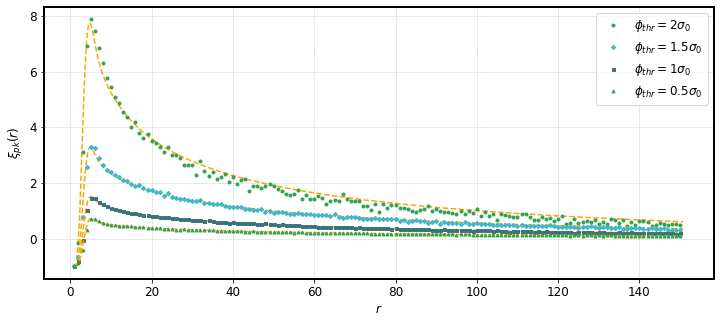

In [82]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['axes.linewidth'] = 2
plot_peak_correlators(150)